# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




Import ART

In [2]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## User parameters

In [3]:
CYCLE = 5

user_params = {
    'bounds_file': f'../flaviolin yield data/Putida_media_bounds_yield.csv',
    'output_dir': f'../flaviolin yield data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin yield data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'combinatorial-media-optimization-for-flavioli-8a70', #DBTL1
    'study_slug_2': 'combinatorial-media-optimization-for-flaviolin-yie',#DBTL2
    'study_slug_3': 'combinatorial-media-optimization-for-flavioli-571b',#DBTL3
    'study_slug_4': 'combinatorial-media-optimization-for-flavioli-ca3a',#DBTL4
    'study_slug_5': 'combinatorial-media-optimization-for-flavioli-2378',#DBTL5
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
}

In [4]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [5]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340yield' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [6]:
user_params['n_instances_explor'] = 3 # number of exploration recommendations
user_params['n_instances_exploit'] = 12 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 42
user_params['cross_val_partitions'] = 4
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [7]:
user_params['alpha_explore'] = 1
user_params['alpha_exploit'] = 0 
user_params['n_iter'] = 1e5

In [8]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False

## Load the data

In [9]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [10]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']


edd_server = user_params['edd_server']
username = user_params['username']

In [11]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

Password for azournas:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [12]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)

    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [13]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin yield data/df_dbtl1-yield.csv')
    df_2 = pd.read_csv('../flaviolin yield data/df_dbtl2-yield.csv')
    df_3 = pd.read_csv('../flaviolin yield data/df_dbtl3-yield.csv')
    df_4 = pd.read_csv('../flaviolin yield data/df_dbtl4-yield.csv')
    df_5 = pd.read_csv('../flaviolin yield data/df_dbtl5-yield.csv')

else:
    df_1.to_csv('../flaviolin yield data/df_dbtl1-yield.csv')
    df_2.to_csv('../flaviolin yield data/df_dbtl2-yield.csv')
    df_3.to_csv('../flaviolin yield data/df_dbtl3-yield.csv')
    df_4.to_csv('../flaviolin yield data/df_dbtl4-yield.csv')
    df_5.to_csv('../flaviolin yield data/df_dbtl5-yield.csv')


## Preprocess the data

Concatenate the six studies:

In [14]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5])

In [15]:
df[df['Protocol'] == 'OD600']

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours


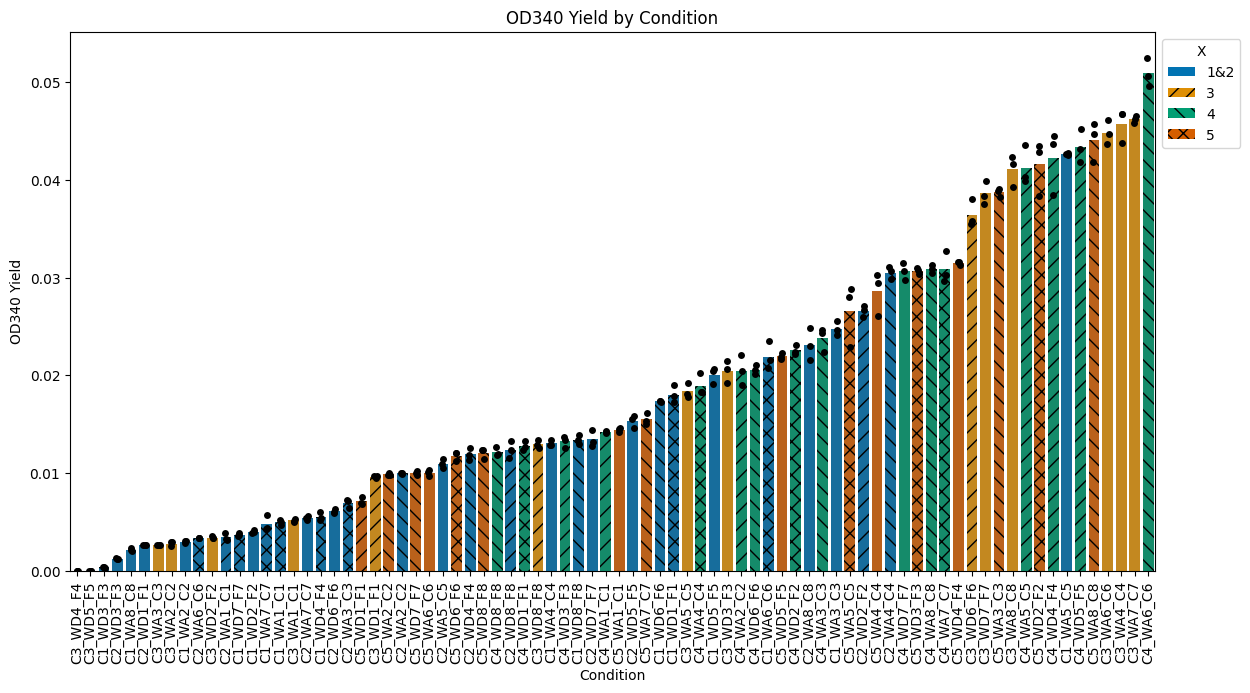

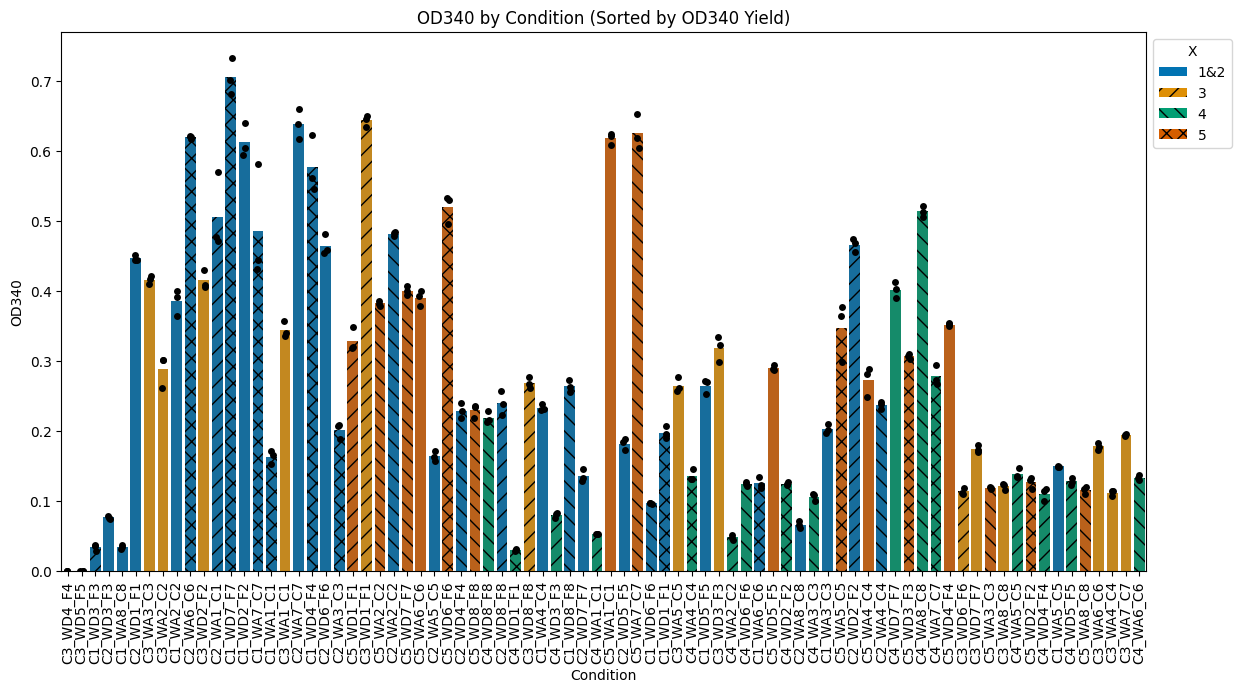

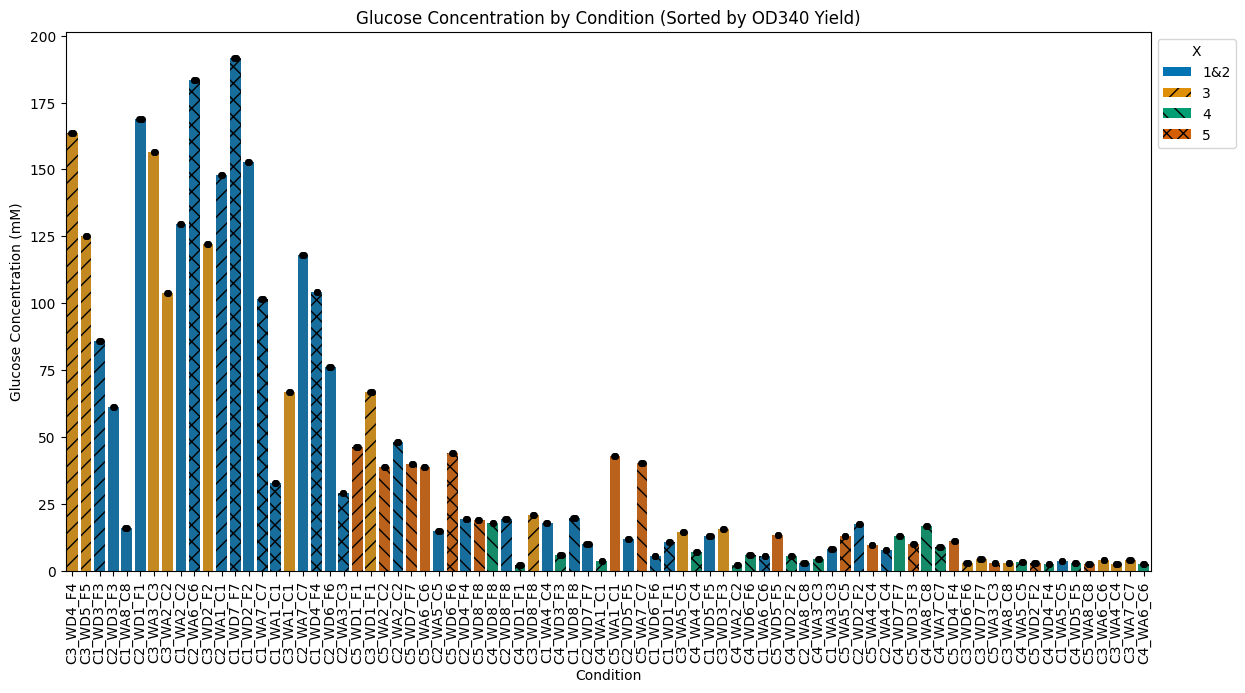

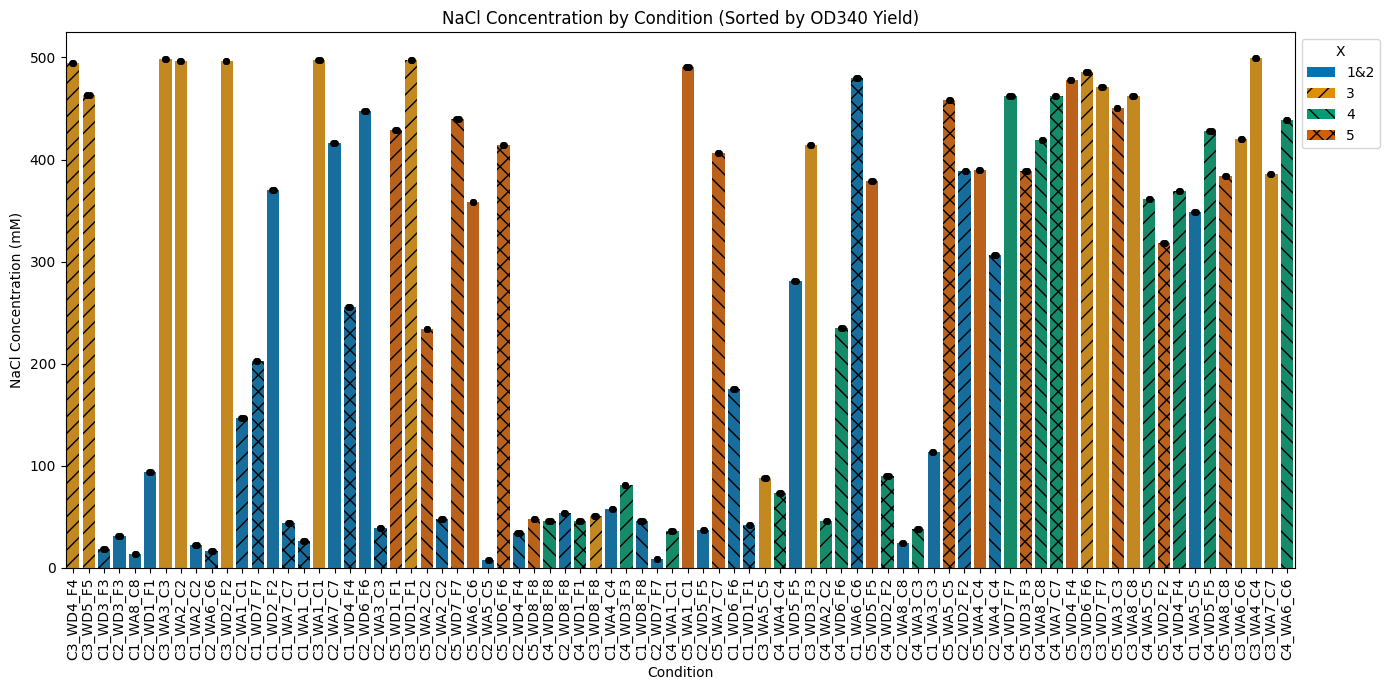

In [16]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming your dataframe is named 'df'
# Create a new column 'condition' by extracting the first part of the "Line Name"
df['condition'] = df['Line Name'].str.rsplit('-', n=1).str[0]

# Create a new column 'X' by extracting the 'X' value from the "Line Name"
df['X'] = df['Line Name'].str.extract('C(\d+)_', expand=False)

# Extract the glucose concentration from the "Line Description" column
def extract_glucose_concentration(description):
    match = re.search(r"Glucose\[mM\]: (\d+\.\d+)", description)
    return float(match.group(1)) if match else None

df['glucose_conc'] = df['Line Description'].apply(extract_glucose_concentration)

# Extract the glucose concentration from the "Line Description" column
def extract_NaCl_concentration(description):
    match = re.search(r"NaCl\[mM\]: (\d+\.\d+)", description)
    return float(match.group(1)) if match else None

df['NaCl_conc'] = df['Line Description'].apply(extract_NaCl_concentration)

# Calculate OD340yield by dividing "Value" by glucose concentration
df['OD340yield'] = df['Value'] / df['glucose_conc']

# Combine X=1 and X=2 into the same category
df['X_combined'] = df['X'].replace({'1': '1&2', '2': '1&2'})

# Calculate mean and std for the grouped data
grouped_mean = df.groupby(['condition', 'X_combined'])[['OD340yield', 'Value', 'glucose_conc', 'NaCl_conc']].mean().reset_index()
grouped_std = df.groupby(['condition', 'X_combined'])[['OD340yield', 'Value', 'glucose_conc', 'NaCl_conc']].std().reset_index()

# Merge mean and std data
grouped_data = pd.merge(grouped_mean, grouped_std, on=['condition', 'X_combined'], suffixes=('_mean', '_std'))

# Group the data by 'condition' and calculate the mean of 'OD340yield', "Value", and 'glucose_conc'
grouped_data = df.groupby(['condition', 'X_combined'])[['OD340yield', 'Value', 'glucose_conc', 'NaCl_conc']].mean().reset_index()

# Sort the data by 'OD340yield' in ascending order
sorted_data = grouped_data.sort_values('OD340yield')

# Create a colorblind-friendly palette with textures
palette = sns.color_palette("colorblind", len(df['X_combined'].unique()))
textures = ["", "//", "\\\\", "xx", "oo", "OO", "..", "**"]
color_map = dict(zip(df['X_combined'].unique(), palette))
texture_map = dict(zip(df['X_combined'].unique(), textures))

# Create the first plot (OD340yield)
plt.figure(figsize=(14, 7))
ax1 = sns.barplot(x='condition', y='OD340yield', hue='X_combined', data=sorted_data, palette=color_map)

# Add hatches manually
for i, bar in enumerate(ax1.patches):
    hatch = texture_map[sorted_data['X_combined'].iloc[i % len(sorted_data['X_combined'])]]
    bar.set_hatch(hatch)

# Sort the original dataframe based on the sorted conditions
sorted_conditions = sorted_data['condition'].tolist()
df_sorted = df.set_index('condition').loc[sorted_conditions].reset_index()

sns.stripplot(x='condition', y='OD340yield', data=df_sorted, color='black', size=5, ax=ax1)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('OD340 Yield')
plt.title('OD340 Yield by Condition')

# Create legend patches for X values
legend_patches = [mpatches.Patch(facecolor=color_map[x], hatch=texture_map[x], label=x) for x in sorted(df['X_combined'].unique())]
plt.legend(handles=legend_patches, title='X', loc='upper left', bbox_to_anchor=(1, 1))

# Create the second plot (Value)
plt.figure(figsize=(14, 7))
ax2 = sns.barplot(x='condition', y='Value', hue='X_combined', data=sorted_data, palette=color_map)

# Add hatches manually
for i, bar in enumerate(ax2.patches):
    hatch = texture_map[sorted_data['X_combined'].iloc[i % len(sorted_data['X_combined'])]]
    bar.set_hatch(hatch)

# Use the sorted dataframe for the swarmplot
sns.stripplot(x='condition', y='Value', data=df_sorted, color='black', size=5, ax=ax2)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('OD340')
plt.title('OD340 by Condition (Sorted by OD340 Yield)')

# Create legend patches for X values
legend_patches = [mpatches.Patch(facecolor=color_map[x], hatch=texture_map[x], label=x) for x in sorted(df['X_combined'].unique())]
plt.legend(handles=legend_patches, title='X', loc='upper left', bbox_to_anchor=(1, 1))

# Create the third plot (Glucose Concentration)
plt.figure(figsize=(14, 7))
ax3 = sns.barplot(x='condition', y='glucose_conc', hue='X_combined', data=sorted_data, palette=color_map)

# Add hatches manually
for i, bar in enumerate(ax3.patches):
    hatch = texture_map[sorted_data['X_combined'].iloc[i % len(sorted_data['X_combined'])]]
    bar.set_hatch(hatch)

# Use the sorted dataframe for the swarmplot
sns.stripplot(x='condition', y='glucose_conc', data=df_sorted, color='black', size=5, ax=ax3)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('Glucose Concentration (mM)')
plt.title('Glucose Concentration by Condition (Sorted by OD340 Yield)')

# Create legend patches for X values
legend_patches = [mpatches.Patch(facecolor=color_map[x], hatch=texture_map[x], label=x) for x in sorted(df['X_combined'].unique())]
plt.legend(handles=legend_patches, title='X', loc='upper left', bbox_to_anchor=(1, 1))

# Create the fourth plot (NaCl Concentration)
plt.figure(figsize=(14, 7))
ax4 = sns.barplot(x='condition', y='NaCl_conc', hue='X_combined', data=sorted_data, palette=color_map)

# Add hatches manually
for i, bar in enumerate(ax4.patches):
    hatch = texture_map[sorted_data['X_combined'].iloc[i % len(sorted_data['X_combined'])]]
    bar.set_hatch(hatch)

# Use the sorted dataframe for the swarmplot
sns.stripplot(x='condition', y='NaCl_conc', data=df_sorted, color='black', size=5, ax=ax4)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('NaCl Concentration (mM)')
plt.title('NaCl Concentration by Condition (Sorted by OD340 Yield)')

# Create legend patches for X values
legend_patches = [mpatches.Patch(facecolor=color_map[x], hatch=texture_map[x], label=x) for x in sorted(df['X_combined'].unique())]
plt.legend(handles=legend_patches, title='X', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [17]:
# Create a function to aggregate individual values
def aggregate_values(series):
    return ', '.join(series.round(4).astype(str))

# Calculate mean, std, and aggregate individual values for OD340yield grouped by 'condition'
od340yield_stats = df.groupby('condition')['OD340yield'].agg(
    OD340yield_mean='mean',
    OD340yield_std='std',
    OD340yield_values=aggregate_values
).reset_index()


od340yield_stats['cv%'] = od340yield_stats['OD340yield_std']/od340yield_stats['OD340yield_mean']
# Display the result
od340yield_stats.sort_values('OD340yield_mean')


,condition,OD340yield_mean,OD340yield_std,OD340yield_values,cv%
43,C3_WD4_F4,6.115259e-07,0.000000,"0.0, 0.0, 0.0",0.000000
44,C3_WD5_F5,7.995490e-07,0.000000,"0.0, 0.0, 0.0",0.000000
10,C1_WD3_F3,3.988243e-04,0.000053,"0.0004, 0.0004, 0.0003",0.132840
26,C2_WD3_F3,1.248964e-03,0.000039,"0.0012, 0.0012, 0.0013",0.031012
7,C1_WA8_C8,2.154888e-03,0.000151,"0.0022, 0.0023, 0.002",0.070175
...,...,...,...,...,...
71,C5_WA8_C8,4.409775e-02,0.002001,"0.0419, 0.0457, 0.0447",0.045378
37,C3_WA6_C6,4.486552e-02,0.001214,"0.0437, 0.0461, 0.0447",0.027067
35,C3_WA4_C4,4.576276e-02,0.001705,"0.0467, 0.0467, 0.0438",0.037248
38,C3_WA7_C7,4.622099e-02,0.000333,"0.0459, 0.0463, 0.0465",0.007212


In [18]:
od340yield_stats.sort_values('cv%')

,condition,OD340yield_mean,OD340yield_std,OD340yield_values,cv%
44,C3_WD5_F5,7.995490e-07,0.000000,"0.0, 0.0, 0.0",0.000000
43,C3_WD4_F4,6.115259e-07,0.000000,"0.0, 0.0, 0.0",0.000000
4,C1_WA5_C5,4.266364e-02,0.000135,"0.0426, 0.0428, 0.0426",0.003166
21,C2_WA6_C6,3.378861e-03,0.000011,"0.0034, 0.0034, 0.0034",0.003392
13,C1_WD6_F6,1.736096e-02,0.000099,"0.0174, 0.0174, 0.0172",0.005705
...,...,...,...,...,...
33,C3_WA2_C2,2.777031e-03,0.000222,"0.0025, 0.0029, 0.0029",0.079916
16,C2_WA1_C1,3.426937e-03,0.000373,"0.0039, 0.0032, 0.0032",0.108891
68,C5_WA5_C5,2.660478e-02,0.003198,"0.0289, 0.028, 0.0229",0.120200
10,C1_WD3_F3,3.988243e-04,0.000053,"0.0004, 0.0004, 0.0003",0.132840


In [19]:
import pandas as pd

# Assuming your data is stored in a DataFrame called 'data_df'
data_df = grouped_data.copy()
# Extract the 'X' part from the 'condition' column
data_df['X'] = data_df['condition'].str.extract('C(\d+)_W')

# Group the data by 'X'
grouped_data = data_df.groupby('X')

# Find the maximum "Value" for each unique 'X'
max_yield = grouped_data['OD340yield'].max()
max_titer = grouped_data['Value'].max()
# Find the "Value" where 'condition' ends with "F8" for each unique 'X'
f8_values_yield = data_df[data_df['condition'].str.endswith('F8')].set_index('X')['OD340yield']
f8_values_titer = data_df[data_df['condition'].str.endswith('F8')].set_index('X')['Value']

# Combine the results into a new DataFrame
result_df = pd.concat([max_titer, f8_values_titer, max_yield, f8_values_yield], axis=1)
result_df.columns = ['Max Titer', 'Standard Titer', 'Max Yield', 'Standard Yield']

result_df['% improvement titer'] = (result_df['Max Titer'] - result_df['Standard Titer'])/result_df['Standard Titer']
result_df['% improvement yield'] = (result_df['Max Yield'] - result_df['Standard Yield'])/result_df['Standard Yield']
# Display the resulting DataFrame
print(result_df)
result_df.to_csv('DBTL_improvements.csv')

   Max Titer  Standard Titer  Max Yield  Standard Yield  % improvement titer  \
X                                                                              
1   0.705900        0.263767   0.042664        0.013431             1.676229   
2   0.638833        0.239867   0.030520        0.012397             1.663285   
3   0.644267        0.268767   0.046221        0.012983             1.397123   
4   0.513967        0.219067   0.050939        0.012164             1.346166   
5   0.625767        0.229500   0.044098        0.012045             1.726652   

   % improvement yield  
X                       
1             2.176535  
2             1.461828  
3             2.560247  
4             3.187744  
5             2.661118  


In [20]:
data_df

,condition,X_combined,OD340yield,Value,glucose_conc,NaCl_conc,X
0,C1_WA1_C1,1&2,0.004957,0.163533,32.989243,26.240883,1
1,C1_WA2_C2,1&2,0.002973,0.385533,129.695160,21.949810,1
2,C1_WA3_C3,1&2,0.024800,0.203067,8.188010,113.696695,1
3,C1_WA4_C4,1&2,0.013048,0.233233,17.875470,58.112395,1
4,C1_WA5_C5,1&2,0.042664,0.149267,3.498686,348.362796,1
...,...,...,...,...,...,...,...
75,C5_WD4_F4,5,0.031499,0.352300,11.184317,478.221158,5
76,C5_WD5_F5,5,0.021967,0.290167,13.208940,378.872203,5
77,C5_WD6_F6,5,0.011797,0.520133,44.090442,413.967865,5
78,C5_WD7_F7,5,0.010022,0.400600,39.973087,439.372131,5


In [21]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5])

In [22]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0


### clean up the df

Drop unnecessary columns:

In [23]:
df = df.loc[:,['Line Name','Line Description','Measurement Type','Value']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [24]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")
df.reset_index(inplace=True)


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [25]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [26]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)


### Include Yield and clean up the training data

Include the Yield column:

In [27]:
df['OD340yield'] = df['OD340']/df['Glucose[mM]']
df['OD340yield']

0      0.005044
1      0.005174
2      0.004653
3      0.003015
4       0.00309
         ...   
235    0.010022
236    0.010187
237    0.012355
238    0.012328
239    0.011452
Name: OD340yield, Length: 240, dtype: object

In [28]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340yield
0,C1_WA1_C1-R1,0.1664,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005044
1,C1_WA1_C1-R2,0.1707,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005174
2,C1_WA1_C1-R3,0.1535,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.004653
3,C1_WA2_C2-R1,0.3910,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.003015
4,C1_WA2_C2-R2,0.4007,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.00309


In [29]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340yield
235,C5_WD7_F7-R2,0.4006,40.0,4.0,0.035459,39.973087,1.934613,0.525783,0.083434,7.301727,1.046385,439.372131,0.000298,0.001534,0.000605,0.00668,0.000854,0.05,0.010022
236,C5_WD7_F7-R3,0.4072,40.0,4.0,0.035459,39.973087,1.934613,0.525783,0.083434,7.301727,1.046385,439.372131,0.000298,0.001534,0.000605,0.00668,0.000854,0.05,0.010187
237,C5_WD8_F8-R1,0.2354,40.0,4.0,0.003911,19.053726,0.308325,1.22719,0.010482,10.032627,0.488226,48.073026,0.00003,0.000304,0.000096,0.000735,0.000091,0.05,0.012355
238,C5_WD8_F8-R2,0.2349,40.0,4.0,0.003911,19.053726,0.308325,1.22719,0.010482,10.032627,0.488226,48.073026,0.00003,0.000304,0.000096,0.000735,0.000091,0.05,0.012328
239,C5_WD8_F8-R3,0.2182,40.0,4.0,0.003911,19.053726,0.308325,1.22719,0.010482,10.032627,0.488226,48.073026,0.00003,0.000304,0.000096,0.000735,0.000091,0.05,0.011452


Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [30]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]

#control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

control_lines = pd.concat([control_lines, df[df['Line Name'].str.find('_F8') > 0]], ignore_index=True)

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [31]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked

,Line Name,Measurement Type,Value
0,C1_WA1_C1-R1,OD340,0.1664
1,C1_WA1_C1-R1,MOPS[mM],40.0
2,C1_WA1_C1-R1,Tricine[mM],4.0
3,C1_WA1_C1-R1,H3BO3[mM],0.003661
4,C1_WA1_C1-R1,Glucose[mM],32.989243
...,...,...,...
4315,C5_WD8_F8-R3,CuSO4[mM],0.000096
4316,C5_WD8_F8-R3,MnSO4[mM],0.000735
4317,C5_WD8_F8-R3,ZnSO4[mM],0.000091
4318,C5_WD8_F8-R3,Kan[g/l],0.05


In [32]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']

### OD340 of the highest performing strains is at 0.7. 
### I multiply the data by 1000 to bring it up to ~700 to improve parallel tempering performance
# df_stacked.loc[df_stacked["Measurement Type"] == "OD340yield", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340yield", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_C1-R1,OD340,0.1664
1,C1_WA1_C1-R1,MOPS[mM],40.0
2,C1_WA1_C1-R1,Tricine[mM],4.0
3,C1_WA1_C1-R1,H3BO3[mM],0.003661
4,C1_WA1_C1-R1,Glucose[mM],32.989243
...,...,...,...
4315,C5_WD8_F8-R3,CuSO4[mM],0.000096
4316,C5_WD8_F8-R3,MnSO4[mM],0.000735
4317,C5_WD8_F8-R3,ZnSO4[mM],0.000091
4318,C5_WD8_F8-R3,Kan[g/l],0.05


## Define functions we will use to train art, generate recommendations and plot the results

In [33]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'cross_val_partitions': user_params['cross_val_partitions'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 1,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False
    }
    
    # art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [34]:

# outliers = ['C2.1_WA7_B1-R1','C2.1_WB8_C2-R1']

# df_stacked = df_stacked[~df_stacked['Line Name'].isin(outliers)]
# df_stacked[df_stacked['Measurement Type'] == 'OD340'].tail(48)

### Train ART

/code/flaviolin_yield_notebooks_final/../art/preprocess.py:716: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r"^\s*$", np.nan, regex=True)
Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 80 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models (2 parallel splits X (L0: sequential, L1: 2 jobs))…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting L0 models…
Building TPOT models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(OneHotEncoder(VarianceThreshold(SelectFwe(input_matrix, alpha=0.049), threshold=0.0001), minimum_fraction=0.25, sparse=False, threshold=10), learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)
Done fitting L0 models in 84.27 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains, 66 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:0000:0100:03


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 45 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 75.18 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(RidgeCV(input_matrix)), learning_rate=0.001, loss=square, n_estimators=100)
Done fitting L0 models in 164.10 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains, 7 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:0000:0100:03


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 44 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 45.33 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(RobustScaler(input_matrix), learning_rate=0.1, max_depth=9, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)
Done fitting L0 models in 83.69 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains, 59 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:0000:0100:02


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 38 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 39.12 s
Best pipeline: ExtraTreesRegressor(StandardScaler(VarianceThreshold(input_matrix, threshold=0.0005)), bootstrap=False, max_features=1.0, min_samples_leaf=3, min_samples_split=11, n_estimators=100)
Done fitting L0 models in 125.88 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains, 45 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:0000:0100:02
Done building ensemble model in 40.45 s


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 39 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.102925,200668.841457,0.085758,0.017948,-91.178630
Random Forest Regressor,0.003549,15690.037166,0.003318,0.000024,0.878774
Support Vector Regressor,0.014028,95656.846418,0.007549,0.000254,-0.303298
Kernel Ridge Regressor,0.006904,20865.424522,0.007191,0.000099,0.489610
K-NN Regressor,0.008549,80462.875230,0.008707,0.000149,0.235280
Gaussian Process Regressor,0.006715,17813.922967,0.006283,0.000085,0.565708
Gradient Boosting Regressor,0.003397,17578.611512,0.003086,0.000021,0.891812
TPOT Regressor,0.003536,17493.380497,0.003184,0.000023,0.883717
Ensemble Model,0.003423,18486.149096,0.002913,0.000020,0.896266


Done with 4-fold cross-validation in 382.82 s


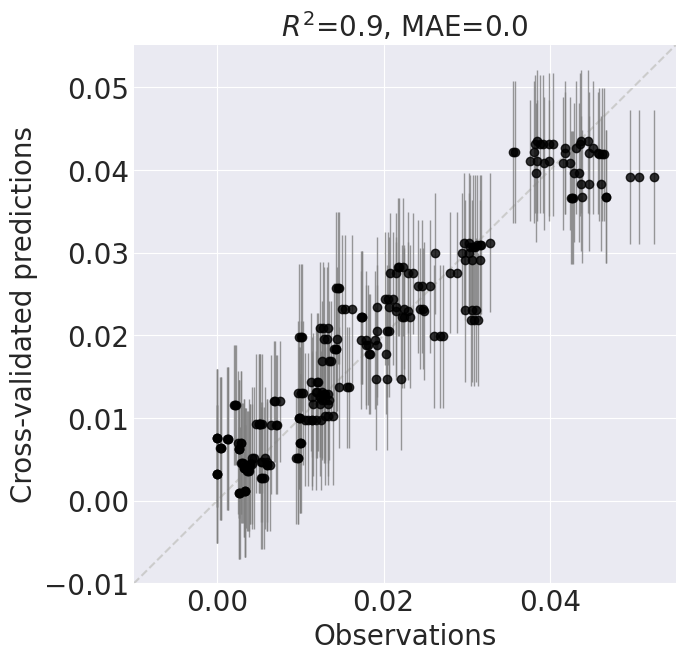

Building models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(PCA(input_matrix, iterated_power=7, svd_solver=randomized), learning_rate=0.1, max_depth=4, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)
Done fitting L0 models in 92.95 s
Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Done building ensemble model in 52.24 s


/code/flaviolin_yield_notebooks_final/../art/core/recommendation_engine.py:772: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Predictions"][:-1] = l0_predictions[j]


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.046961,166424.425001,0.039680,3.779815e-03,-18.412625
Random Forest Regressor,0.000599,345.001281,0.000680,8.218144e-07,0.995779
Support Vector Regressor,0.014124,95052.807049,0.007250,2.520639e-04,-0.294567
Kernel Ridge Regressor,0.001688,3414.763139,0.001628,5.497685e-06,0.971765
K-NN Regressor,0.003745,31432.020014,0.003929,2.946548e-05,0.848669
Gaussian Process Regressor,0.000552,49.647904,0.000648,7.237878e-07,0.996283
Gradient Boosting Regressor,0.000560,182.291297,0.000643,7.272223e-07,0.996265
TPOT Regressor,0.000698,1751.682377,0.000752,1.053237e-06,0.994591
Ensemble Model,0.000713,2280.786063,0.000735,1.049234e-06,0.994611


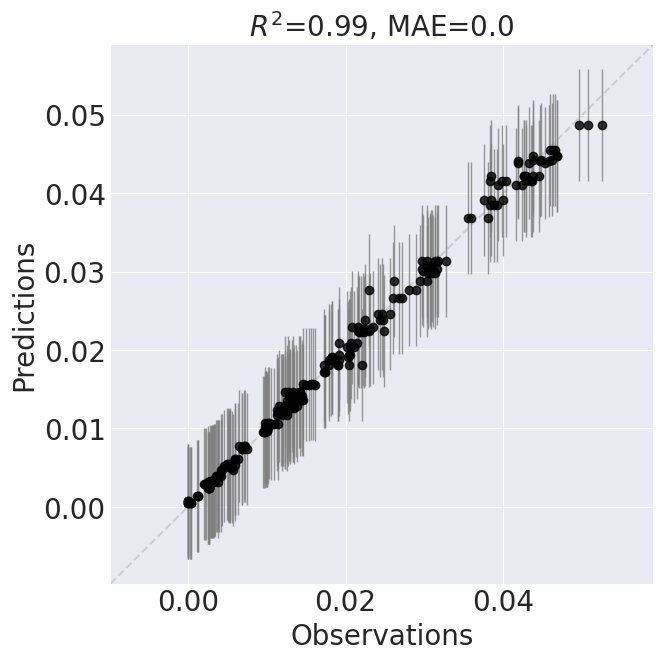

Done building models in 149.04 s


In [35]:
art = train_art(df_stacked, user_params, 'art_yield_DBTL6.cpkl')
# import cloudpickle

# with open('../flaviolin data/DBTL3.2/art_x100_outlier_removed.cpkl', "rb") as f:
#     art = cloudpickle.load(f)


### Run SHAP analysis

In [36]:
import shap
shap.__version__

'0.45.0'

In [38]:
def f(X):
    return art.predict(X)


In [41]:
user_params['components'] = [
    '$H_3BO_3[mM]$',
    '$Glucose[mM]$',
    '$K_2SO_4[mM]$',
    '$K_2HPO_4[mM]$',
    '$FeSO_4[mM]$',
    '$NH_4Cl[mM]$',
    '$MgCl_2[mM]$',
    '$NaCl[mM]$',
    '$(NH_4)_6Mo_7O_{24}[mM]$',
    '$CoCl_2[mM]$',
    '$CuSO_4[mM]$',
    '$MnSO_4[mM]$',
    '$ZnSO_4[mM]$',
    # 'CaCl2[mM]'    
]

In [42]:
X_df = pd.DataFrame(art.X, columns = user_params['components'])
explainer_e = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

PermutationExplainer explainer: 241it [02:31,  1.49it/s]                         


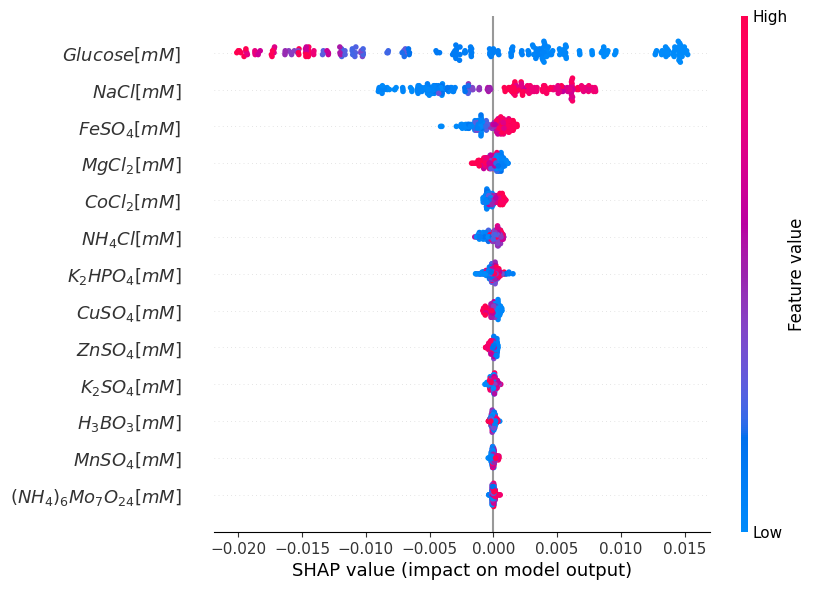

In [43]:
fig = plt.figure(figsize=(9,4.5))
shap.plots.beeswarm(shap_values_e, max_display=20)